In [2]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
import pickle
from sklearn import preprocessing
import sklearn
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import networkx as nx
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle

### notebook specific configuration ###
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2


! if [ ! -d /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_analysis/ ]; then mkdir /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_analysis; fi

os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/dhcr24_analysis/')

## Copy Files

In [92]:
%%bash
# get differentially expressed gene files
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_mouseMacrophage_analysis/homer_diffExpresion.tsv ./human_diffExpression.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_humanMacrophage_analysis/homer_diffExpresion.tsv ./mouse_diffExpression.tsv

# get IDR scores
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_mouseMacrophage_analysis/idr/ThioMac_Des_idrUnion.tsv ./mouse_des_idrUnion.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_mouseMacrophage_analysis/idr/ThioMac_DMHCA_idrUnion.tsv ./mouse_dmhca_idrUnion.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_mouseMacrophage_analysis/idr/ThioMac_T09_idrUnion.tsv ./mouse_t09_idrUnion.tsv

cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_humanMacrophage_analysis/idr/Human_Des_idrUnion.tsv ./human_des_idrUnion.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_humanMacrophage_analysis/idr/Human_DMHCA_idrUnion.tsv ./human_dhmca_idrUnion.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_humanMacrophage_analysis/idr/Human_T09_idrUnion.tsv ./human_t09_idrUnion.tsv

# get rpkm values
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_mouseMacrophage_analysis/idr/idr_union_rpkm.tsv ./mouse_idr_rpkm.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_humanMacrophage_analysis/idr/idr_union_rpkm.tsv ./human_idr_rpkm.tsv



## Integrate IDR Scores with EdgeR

In [155]:
condition_significantGenes_dict = {}

In [156]:
### Read in EdgeR Values

# human
diffExpression_human_frame = pd.read_csv('human_diffExpression.tsv', sep='\t')
columns = diffExpression_human_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
diffExpression_human_frame.columns=columns
diffExpression_human_frame['gene'] = [x.split('|')[0].upper() for x in diffExpression_human_frame['Divergence']]
diffExpression_human_frame.index = diffExpression_human_frame.gene.values
columns = ['refseq', 'gene'] + [x for x in diffExpression_human_frame.columns if 'vs.' in x]
diffExpression_human_frame = diffExpression_human_frame[columns]

# mouse
diffExpression_mouse_frame = pd.read_csv('mouse_diffExpression.tsv', sep='\t')
columns = diffExpression_mouse_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
diffExpression_mouse_frame.columns=columns
diffExpression_mouse_frame['gene'] = [x.split('|')[0].upper() for x in diffExpression_mouse_frame['Divergence']]
diffExpression_mouse_frame.index = diffExpression_mouse_frame.gene.values
columns = ['refseq', 'gene'] + [x for x in diffExpression_mouse_frame.columns if 'vs.' in x]
diffExpression_mouse_frame = diffExpression_mouse_frame[columns]

In [157]:
### integrate mouse scores
treatments = ['Des', 'DMHCA', 'T09']
p_threshold = 0.05
fold_threshold = np.log2(2)
for treatment in treatments:
    idr_frame = pd.read_csv('mouse_' + treatment.lower() + '_idrUnion.tsv', sep='\t')
    idr_frame.index = [x.split('|')[0].upper() for x in idr_frame['annotation'].values]
    
    significant_frame = diffExpression_mouse_frame[
                            (diffExpression_mouse_frame[treatment + ' vs. Vehicle adj. p-value'] < p_threshold) &
                            (diffExpression_mouse_frame[treatment + ' vs. Vehicle Log2 Fold Change'].abs() > fold_threshold) &
                            (diffExpression_mouse_frame.index.isin(idr_frame.index.values))
                        ][[treatment + ' vs. Vehicle adj. p-value', treatment + ' vs. Vehicle Log2 Fold Change']]

    significant_idr_frame = idr_frame[idr_frame.index.isin(significant_frame.index.values)]
    gene_idrScore_dict = dict(zip(significant_idr_frame.index.values, 
                                  [[int(y) for y in x.split(', ')] for x in significant_idr_frame['idrScore']]))
    idr_means = []
    idr_medians = []
    idr_mins = []
    idr_maxes = []
    count = 0
    for gene in significant_frame.index.values:
        idr_vals = gene_idrScore_dict[gene]
        idr_means.append(np.mean(idr_vals))
        idr_medians.append(np.median(idr_vals))
        idr_mins.append(np.min(idr_vals))
        idr_maxes.append(np.max(idr_vals))
        
#     significant_frame['IDR Min'] = idr_mins
    significant_frame['IDR Mean'] = idr_means
    significant_frame['IDR Median'] = idr_medians
#     significant_frame['IDR Max'] = idr_maxes
    significant_frame = significant_frame.sort(treatment + ' vs. Vehicle adj. p-value')
    # down regulated genes
    significant_frame[significant_frame[treatment + ' vs. Vehicle Log2 Fold Change'] < 0].to_csv('mouse_'+treatment+'_down_scores.tsv',sep='\t')
    condition_significantGenes_dict['mouse_' + treatment.lower() + '_down'] = significant_frame[significant_frame[treatment + ' vs. Vehicle Log2 Fold Change'] < 0].index.values
    # upregulated genes
    significant_frame[significant_frame[treatment + ' vs. Vehicle Log2 Fold Change'] > 0].to_csv('mouse_'+treatment+'_up_scores.tsv',sep='\t')
    condition_significantGenes_dict['mouse_' + treatment.lower() + '_up'] = significant_frame[significant_frame[treatment + ' vs. Vehicle Log2 Fold Change'] > 0].index.values

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:34: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [158]:
### integrate human scores
treatments = ['Des', 'DMHCA', 'T09']
p_threshold = 0.05
fold_threshold = np.log2(2)
for treatment in treatments:
    idr_frame = pd.read_csv('human_' + treatment.lower() + '_idrUnion.tsv', sep='\t')
    idr_frame.index = [x.split('|')[0].upper() for x in idr_frame['annotation'].values]
    
    significant_frame = diffExpression_human_frame[
                            (diffExpression_human_frame[treatment + ' vs. Vehicle FDR'] < p_threshold) &
                            (diffExpression_human_frame[treatment + ' vs. Vehicle logFC'].abs() > fold_threshold) &
                            (diffExpression_human_frame.index.isin(idr_frame.index.values))
                        ][[treatment + ' vs. Vehicle FDR', treatment + ' vs. Vehicle logFC']]

    significant_idr_frame = idr_frame[idr_frame.index.isin(significant_frame.index.values)]
    gene_idrScore_dict = dict(zip(significant_idr_frame.index.values, 
                                  [[int(y) for y in x.split(', ')] for x in significant_idr_frame['idrScore']]))
    idr_means = []
    idr_medians = []
    idr_mins = []
    idr_maxes = []
    count = 0
    for gene in significant_frame.index.values:
        idr_vals = gene_idrScore_dict[gene]
        idr_means.append(np.mean(idr_vals))
        idr_medians.append(np.median(idr_vals))
        idr_mins.append(np.min(idr_vals))
        idr_maxes.append(np.max(idr_vals))
        
#     significant_frame['IDR Min'] = idr_mins
    significant_frame['IDR Mean'] = idr_means
    significant_frame['IDR Median'] = idr_medians
#     significant_frame['IDR Max'] = idr_maxes
    significant_frame = significant_frame.sort(treatment + ' vs. Vehicle FDR')
    # down regulated genes
    significant_frame[significant_frame[treatment + ' vs. Vehicle logFC'] < 0].to_csv('human_'+treatment+'_down_scores.tsv',sep='\t')
    condition_significantGenes_dict['human_' + treatment.lower() + '_down'] = significant_frame[significant_frame[treatment + ' vs. Vehicle logFC'] < 0].index.values
    # upregulated genes
    significant_frame[significant_frame[treatment + ' vs. Vehicle logFC'] > 0].to_csv('human_'+treatment+'_up_scores.tsv',sep='\t')
    condition_significantGenes_dict['human_' + treatment.lower() + '_up'] = significant_frame[significant_frame[treatment + ' vs. Vehicle logFC'] > 0].index.values

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:34: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


### Human DMHCA

In [9]:
human_dmhca_down_genes = set()
with open ('/home/jtao/analysis/dhcr24_MTP_analysis/gene_ontology/DMHCA_down.txt') as f:
    data = f.readlines()
for gene in data:
    human_dmhca_down_genes.add(gene.strip())
human_dmhca_up_genes = set()
with open ('/home/jtao/analysis/dhcr24_MTP_analysis/gene_ontology/DMHCA_up.txt') as f:
    data = f.readlines()
for gene in data:
    human_dmhca_up_genes.add(gene.strip())

### Human Des

In [10]:
human_des_down_genes = set()
with open ('/home/jtao/analysis/dhcr24_MTP_analysis/gene_ontology/Des_down.txt') as f:
    data = f.readlines()
for gene in data:
    human_des_down_genes.add(gene.strip())
human_des_up_genes = set()
with open ('/home/jtao/analysis/dhcr24_MTP_analysis/gene_ontology/Des_up.txt') as f:
    data = f.readlines()
for gene in data:
    human_des_up_genes.add(gene.strip())

### Mouse DMHCA

In [11]:
mouse_dmhca_down_genes = set()
with open ('/home/jtao/analysis/dhcr24_thiomac_analysis/gene_ontology/DMHCA_down.txt') as f:
    data = f.readlines()
for gene in data:
    mouse_dmhca_down_genes.add(gene.strip())
mouse_dmhca_up_genes = set()
with open ('/home/jtao/analysis/dhcr24_thiomac_analysis/gene_ontology/DMHCA_up.txt') as f:
    data = f.readlines()
for gene in data:
    mouse_dmhca_up_genes.add(gene.strip())

### Mouse Des

In [12]:
mouse_des_down_genes = set()
with open ('/home/jtao/analysis/dhcr24_thiomac_analysis/gene_ontology/Des_down.txt') as f:
    data = f.readlines()
for gene in data:
    mouse_des_down_genes.add(gene.strip())
mouse_des_up_genes = set()
with open ('/home/jtao/analysis/dhcr24_thiomac_analysis/gene_ontology/Des_up.txt') as f:
    data = f.readlines()
for gene in data:
    mouse_des_up_genes.add(gene.strip())

### Comparisons

### Des

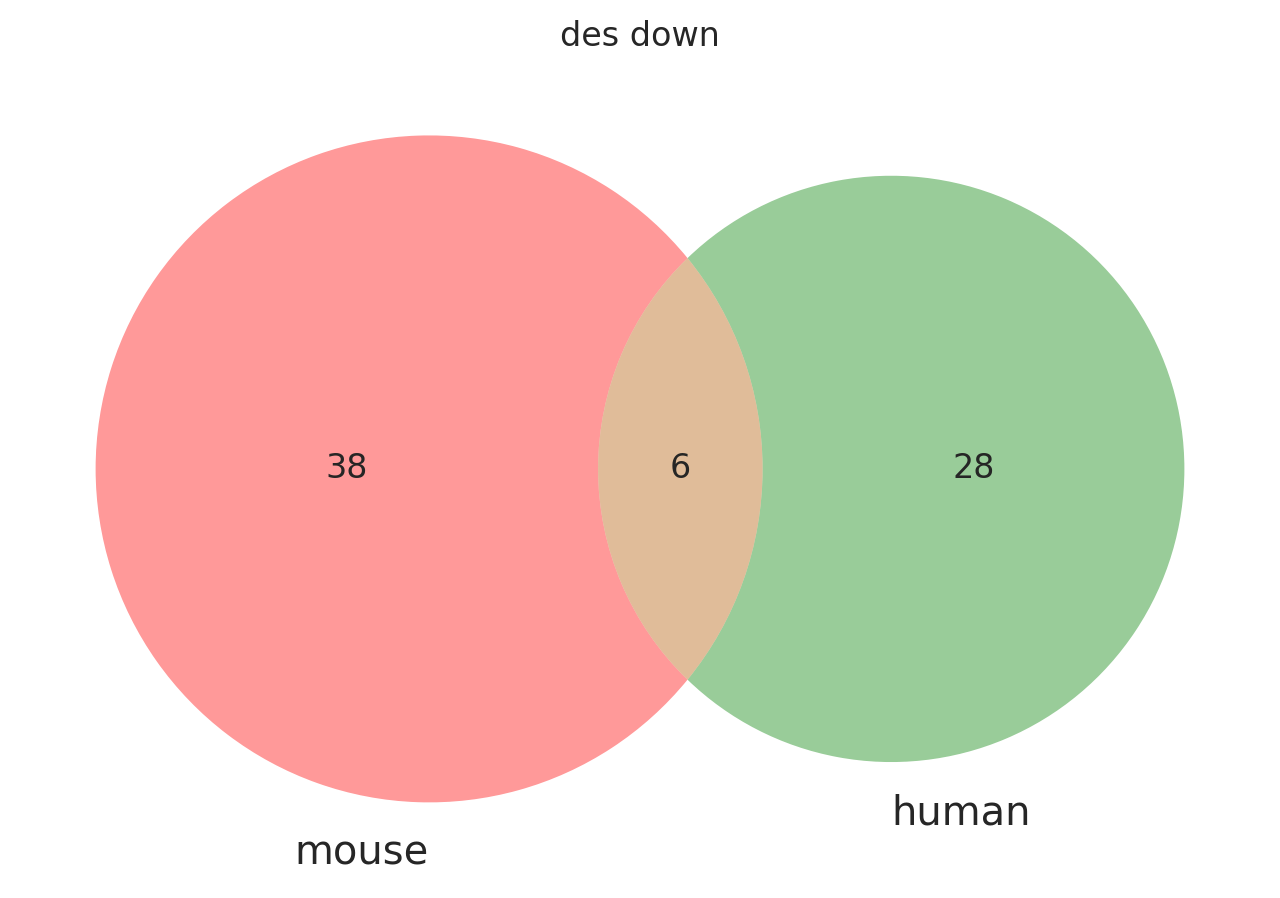

In [160]:
# create venn diagram
treatment = 'des'
direction = 'down'
# gene_sets = [mouse_des_down_genes, human_des_down_genes]
gene_sets = [set(condition_significantGenes_dict['mouse_' + treatment+'_'+direction]),
            set(condition_significantGenes_dict['human_' + treatment+'_'+direction])]
matplotlib_venn.venn2(gene_sets,set_labels=['mouse','human'])
plt.title(treatment + ' ' + direction)

plt.savefig(treatment + '_' + direction + '_vennDiagram.pdf', bbox_inches='tight')

# create gene list
set_dict = {}
set_dict['mouse'] = sorted(gene_sets[0] - gene_sets[1])
set_dict['intersection'] = sorted(gene_sets[0].intersection(gene_sets[1]))
set_dict['human'] = sorted(gene_sets[1] - gene_sets[0])

# add blank spaces so all lists are the same length
max_length = 0 
for key in ['mouse', 'intersection', 'human']:
    if len(set_dict[key]) > max_length:
        max_length = len(set_dict[key])
for key in ['mouse', 'intersection', 'human']:
    current_genes = set_dict[key]
    while len(current_genes) < max_length:
        current_genes.append('')
    set_dict[key] = current_genes
current_frame = pd.DataFrame(set_dict, columns=['mouse', 'intersection', 'human'])

current_frame.to_csv(treatment + '_' + direction + '_geneList.tsv', sep='\t')

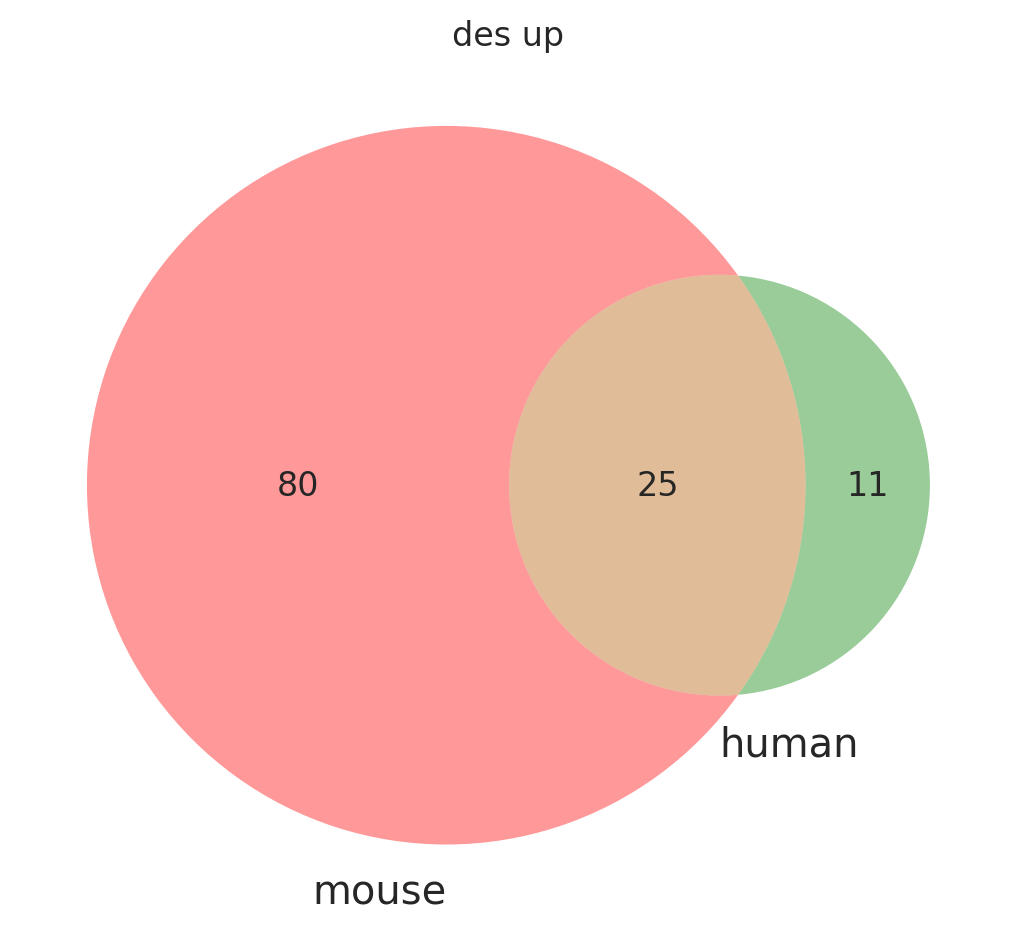

In [161]:
# create venn diagram
treatment = 'des'
direction = 'up'
# gene_sets = [mouse_des_up_genes, human_des_up_genes]
# gene_sets = [condition_significantGenes_dict[]]
gene_sets = [set(condition_significantGenes_dict['mouse_' + treatment+'_'+direction]),
            set(condition_significantGenes_dict['human_' + treatment+'_'+direction])]
matplotlib_venn.venn2(gene_sets,set_labels=['mouse','human'])
plt.title(treatment + ' ' + direction)

plt.savefig(treatment + '_' + direction + '_vennDiagram.pdf', bbox_inches='tight')

# create gene list
set_dict = {}
set_dict['mouse'] = sorted(gene_sets[0] - gene_sets[1])
set_dict['intersection'] = sorted(gene_sets[0].intersection(gene_sets[1]))
set_dict['human'] = sorted(gene_sets[1] - gene_sets[0])

# add blank spaces so all lists are the same length
max_length = 0 
for key in ['mouse', 'intersection', 'human']:
    if len(set_dict[key]) > max_length:
        max_length = len(set_dict[key])
for key in ['mouse', 'intersection', 'human']:
    current_genes = set_dict[key]
    while len(current_genes) < max_length:
        current_genes.append('')
    set_dict[key] = current_genes
current_frame = pd.DataFrame(set_dict, columns=['mouse', 'intersection', 'human'])

current_frame.to_csv(treatment + '_' + direction + '_geneList.tsv', sep='\t')

### DMHCA

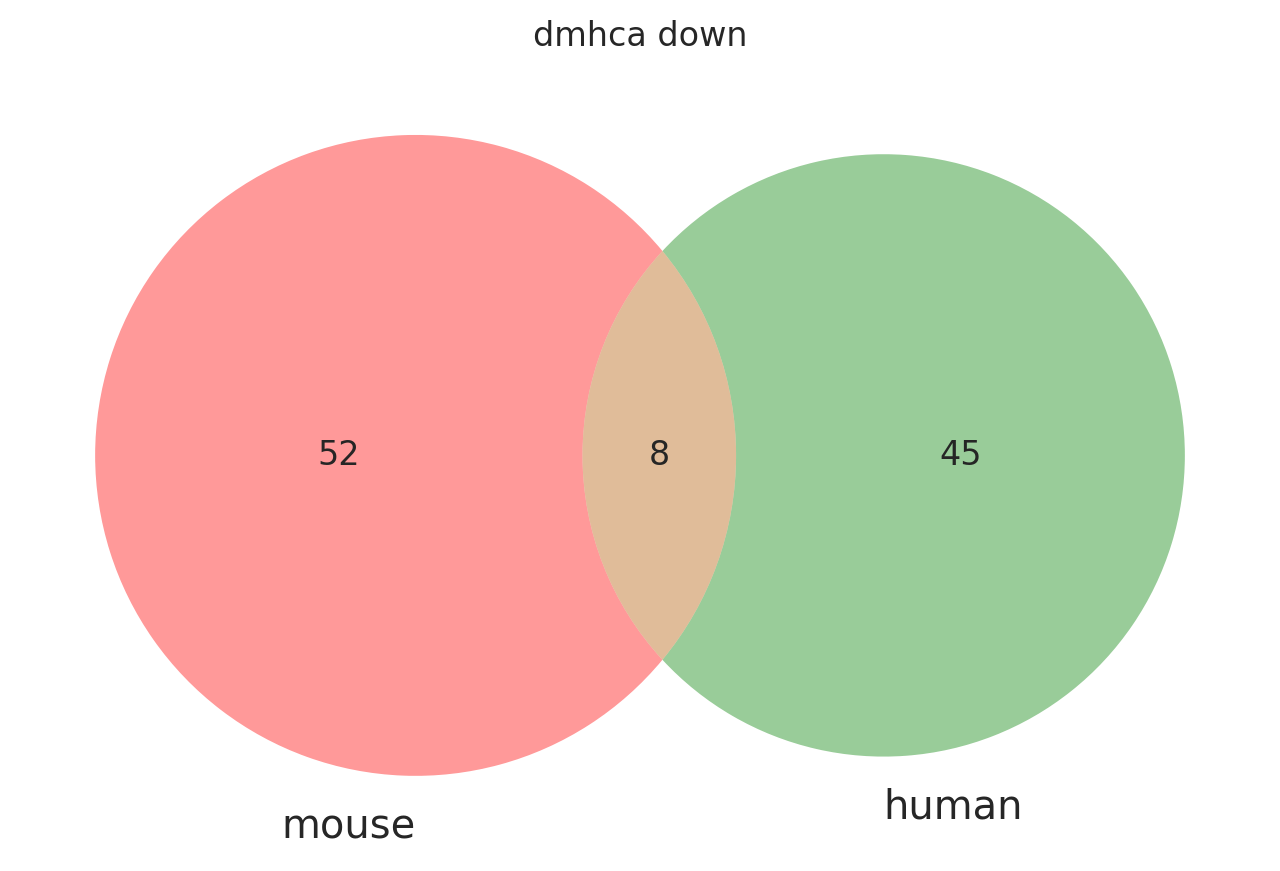

In [162]:
# create venn diagram
treatment = 'dmhca'
direction = 'down'
# gene_sets = [mouse_dmhca_down_genes, human_dmhca_down_genes]
gene_sets = [set(condition_significantGenes_dict['mouse_' + treatment+'_'+direction]),
            set(condition_significantGenes_dict['human_' + treatment+'_'+direction])]
matplotlib_venn.venn2(gene_sets,set_labels=['mouse','human'])
plt.title(treatment + ' ' + direction)

plt.savefig(treatment + '_' + direction + '_vennDiagram.pdf', bbox_inches='tight')

# create gene list
set_dict = {}
set_dict['mouse'] = sorted(gene_sets[0] - gene_sets[1])
set_dict['intersection'] = sorted(gene_sets[0].intersection(gene_sets[1]))
set_dict['human'] = sorted(gene_sets[1] - gene_sets[0])

# add blank spaces so all lists are the same length
max_length = 0 
for key in ['mouse', 'intersection', 'human']:
    if len(set_dict[key]) > max_length:
        max_length = len(set_dict[key])
for key in ['mouse', 'intersection', 'human']:
    current_genes = set_dict[key]
    while len(current_genes) < max_length:
        current_genes.append('')
    set_dict[key] = current_genes
current_frame = pd.DataFrame(set_dict, columns=['mouse', 'intersection', 'human'])

current_frame.to_csv(treatment + '_' + direction + '_geneList.tsv', sep='\t')

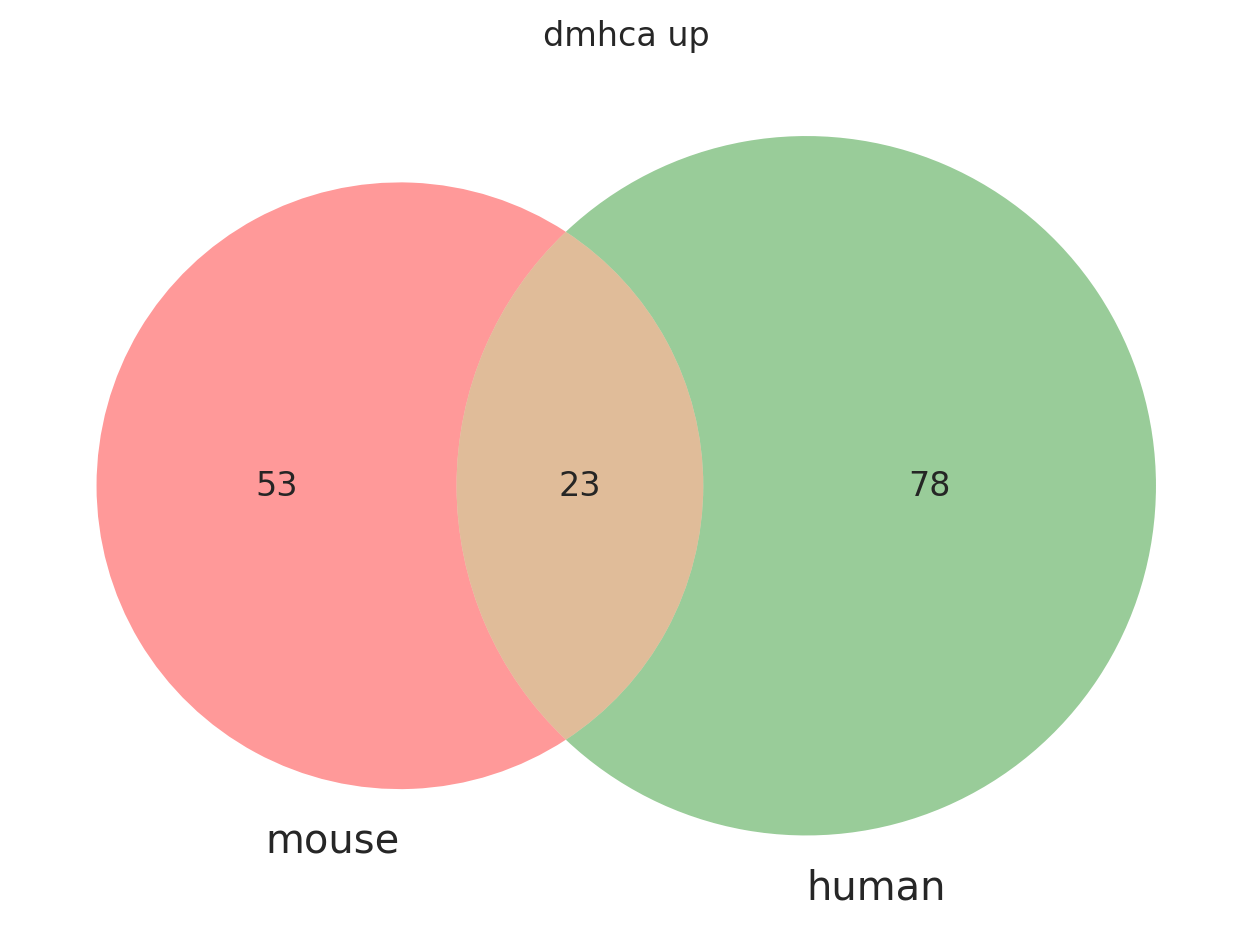

In [163]:
# create venn diagram
treatment = 'dmhca'
direction = 'up'
gene_sets = [mouse_dmhca_up_genes, human_dmhca_up_genes]
gene_sets = [set(condition_significantGenes_dict['mouse_' + treatment+'_'+direction]),
            set(condition_significantGenes_dict['human_' + treatment+'_'+direction])]
matplotlib_venn.venn2(gene_sets,set_labels=['mouse','human'])
plt.title(treatment + ' ' + direction)

plt.savefig(treatment + '_' + direction + '_vennDiagram.pdf', bbox_inches='tight')

# create gene list
set_dict = {}
set_dict['mouse'] = sorted(gene_sets[0] - gene_sets[1])
set_dict['intersection'] = sorted(gene_sets[0].intersection(gene_sets[1]))
set_dict['human'] = sorted(gene_sets[1] - gene_sets[0])

# add blank spaces so all lists are the same length
max_length = 0 
for key in ['mouse', 'intersection', 'human']:
    if len(set_dict[key]) > max_length:
        max_length = len(set_dict[key])
for key in ['mouse', 'intersection', 'human']:
    current_genes = set_dict[key]
    while len(current_genes) < max_length:
        current_genes.append('')
    set_dict[key] = current_genes
current_frame = pd.DataFrame(set_dict, columns=['mouse', 'intersection', 'human'])

current_frame.to_csv(treatment + '_' + direction + '_geneList.tsv', sep='\t')

## Variance Stuff

In [73]:
# read in human rpkm values
idr_rpkm_human_frame = pd.read_csv('./human_idr_rpkm.tsv', sep='\t')

columns = idr_rpkm_human_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
idr_rpkm_human_frame.columns = columns    
idr_rpkm_human_frame['gene'] = [x.split("|")[0].upper() for x in idr_rpkm_human_frame['Annotation/Divergence']]
columns = list(idr_rpkm_human_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
idr_rpkm_human_frame = idr_rpkm_human_frame[columns]
idr_rpkm_human_frame.index = idr_rpkm_human_frame['gene'].values
idr_rpkm_human_frame = idr_rpkm_human_frame.ix[:,9:]

# determine treatment corresponding to each column
human_treatment_col_dict = {}
for col in idr_rpkm_human_frame.columns.values:
    treatment = col.split('_')[2]
    if not treatment in human_treatment_col_dict:
        human_treatment_col_dict[treatment] = [col]
    else:
        human_treatment_col_dict[treatment].append(col)


In [74]:
# read in mouse rpkm values
idr_rpkm_mouse_frame = pd.read_csv('./mouse_idr_rpkm.tsv', sep='\t')

columns = idr_rpkm_mouse_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
idr_rpkm_mouse_frame.columns = columns    
idr_rpkm_mouse_frame['gene'] = [x.split("|")[0].upper() for x in idr_rpkm_mouse_frame['Annotation/Divergence']]
columns = list(idr_rpkm_mouse_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
idr_rpkm_mouse_frame = idr_rpkm_mouse_frame[columns]
idr_rpkm_mouse_frame.index = idr_rpkm_mouse_frame['gene'].values
idr_rpkm_mouse_frame = idr_rpkm_mouse_frame.ix[:,9:]

# determine treatment corresponding to each column
mouse_treatment_col_dict = {}
for col in idr_rpkm_mouse_frame.columns.values:
    treatment = col.split('_')[2]
    if not treatment in mouse_treatment_col_dict:
        mouse_treatment_col_dict[treatment] = [col]
    else:
        mouse_treatment_col_dict[treatment].append(col)

